#Demo for HAR load_dataset functions
load_dataset_demo.ipynb

This is a brief demo and simple test of the load_dataset functions that convert the raw time based accelerometer data and human activity recognition (HAR) labels to trainX, trainy, testX, testy numpy arrays. 
* Builds numpy arrays using load_dataset functions and default arguments
* Builds/Trains/Evaluates a 1D CNN classifier for the selected dataset
* Displays several model evaluation figures and metrics

Comments:  MobiAct and UniMiB SHAR accuracies exceed 90% using total acceleration, UCI HAR and e4_Nov2019 have difficulty with standing/laying/sitting so component acceleration is included which increases overall accruacies.   This may not generalize well if the training set does not include a case where the device orientation is similar to the test case.  i.e. using component accel introduces orientation "awareness" and may hurt generalization.
The e4 data set is very small making it easy to experiment with but the loss curves will not be nearly as uniform and it is easy to overfit the data. 

Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2023

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

TODO:
* This version is work-in-progress to run without drive mount on public repo.
* Make a run-all option or ability to select more than one dataset.
* Refactor the model and training to support more than one model.

#Imports

In [1]:
import os
import shutil
import urllib.request # to get files from web w/o !wget
from scipy import io #for loadmat, matlab conversion
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves

# to measure and display training time
import time
from datetime import timedelta

# model library and functions
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from tensorflow.keras.callbacks import EarlyStopping

# for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

# temp - needed for SHL split
from sklearn.model_selection import train_test_split

In [2]:
def get_py_file(fname, url):
    """checks for local file, if none downloads from URL.    
    :return: nothing"""
    if (os.path.exists(fname)):
        print ("Local",fname, "found, skipping download")
    else:
        print("Downloading",fname, "from IMICS git repo")
        urllib.request.urlretrieve(url, filename=fname)

get_py_file(fname = 'load_data_utils.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_utils.py')

In [3]:
import load_data_utils as utils
print(utils.get_env_info())

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
GPU: NVIDIA-SMI failed, no GPU found


In [5]:
#@title Select Dataset
dataset = "Gesture Phase Segmentation" #@param ["MobiAct HAR", "UniMiB SHAR","UCI HAR","TWristAR","Leotta_2021","SHL","Gesture Phase Segmentation"]

print("Using",dataset,"dataset")
if (dataset == 'Leotta_2021'):
    print ("NOTE: this dataset requires a high-RAM runtime on colab")

Using Gesture Phase Segmentation dataset


#Get numpy arrays from load_dataset

In [6]:
# Copy selected .py file into colab and import load_dataset function
# k_size is the size of the kernel used in the model, one-half of a second
# works well, actual value is based on sample freq e.g. 32Hz -> k_size = 16.
# EPOCHS are max run, training also has early stopping callback
if (dataset == 'MobiAct HAR'):
    full_filename = my_path+os.path.join('/HAR/MobiAct/'+'mobiact_adl_load_dataset.py')
    shutil.copy(full_filename,'mobiact_adl_load_dataset.py')
    from mobiact_adl_load_dataset import mobiact_adl_load_dataset
    x_train, y_train, x_validate, y_validate, x_test, y_test = mobiact_adl_load_dataset(incl_val_group = True)
    k_size = 50
    EPOCHS = 50
    t_names = ['JOG','JUM','STD','STN','STU','WAL']
elif (dataset == 'UniMiB SHAR'):
    full_filename = my_path+ os.path.join('/HAR/UniMiB_SHAR/'+'unimib_shar_adl_load_dataset.py')
    shutil.copy(full_filename,'unimib_shar_adl_load_dataset.py')
    from unimib_shar_adl_load_dataset import unimib_load_dataset
    x_train, y_train, x_validate, y_validate, x_test, y_test = unimib_load_dataset(incl_val_group = True)
    t_names = ['StandingUpFS','StandingUpFL','Walking','Running','GoingUpS','Jumping','GoingDownS','LyingDownFS','SittingDown']
    k_size = 50
    EPOCHS = 60
elif (dataset == 'UCI HAR'):
    full_filename = my_path+os.path.join('/HAR/UCI_HAR/'+'uci_har_load_dataset.py')
    shutil.copy(full_filename,'uci_har_load_dataset.py')
    from uci_har_load_dataset import uci_har_load_dataset
    x_train, y_train, x_validate, y_validate, x_test, y_test = uci_har_load_dataset(incl_val_group = True, incl_xyz_accel= True)
    t_names = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
    k_size = 50
    EPOCHS = 120
elif (dataset == 'TWristAR'):
    full_filename = my_path+os.path.join('/HAR/e4_wristband_Nov2019/'+'e4_load_dataset.py')
    shutil.copy(full_filename,'e4_load_dataset.py')
    from e4_load_dataset import e4_load_dataset
    x_train, y_train, x_validate, y_validate, x_test, y_test = e4_load_dataset(incl_val_group = True, incl_xyz_accel= True)
    t_names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
    k_size = 16
    EPOCHS = 100
elif (dataset == 'Leotta_2021'):
    full_filename = my_path+os.path.join('/ADL/Leotta_2021/'+'leotta_2021_load_dataset.py')
    shutil.copy(full_filename,'leotta_2021_load_dataset.py')
    from leotta_2021_load_dataset import leotta_2021_load_dataset
    x_train, y_train, x_validate, y_validate, x_test, y_test, log_info = leotta_2021_load_dataset(incl_val_group = True)
    # Note:  OTHER referenced in readme.txt was deleted during the processing,
    # and the one-hot encoding shifted everything by one, hence RELAX = 0 now
    t_names = ['RELAX','KEYBOARD_WRITING','LAPTOP','HANDWRITING',
                'HANDWASHING','FACEWASHING','TEETHBRUSH','SWEEPING','VACUUMING',
                'EATING','DUSTING','RUBBING','DOWNSTAIRS','WALKING',
                'WALKING_FAST','UPSTAIRS_FAST','UPSTAIRS']
    k_size = 100
    EPOCHS = 50
elif (dataset == 'SHL'):
    # SHL takes about 30 minutes to process due to size, using saved arrays for now
    input_dir = '/content/drive/MyDrive/Processed_Datasets/shl/train_test_20hz'
    x_train = np.load(input_dir + '/'+'x_train.npy')
    x_train = np.delete(x_train, [0,1,2], 2) # delete component accel
    x_test = np.load(input_dir + '/'+'x_test.npy')
    x_test = np.delete(x_test, [0,1,2], 2) # delete component accel
    y_train = np.load(input_dir + '/'+'y_train.npy')
    y_test = np.load(input_dir + '/'+'y_test.npy')
    # also don't have validate working in SHL so just using stratify
    x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.10, random_state=42, stratify=y_train)

    t_names = ['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
    k_size = 15
    EPOCHS = 100
elif (dataset == 'Gesture Phase Segmentation'):
    get_py_file(fname = 'gesture_phase_segmentation_load_dataset.py', 
                url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/Gesturing_Signing/gesture_phase_segmentation_load_dataset.py')
    from gesture_phase_segmentation_load_dataset import gesture_phase_segmentation_load_dataset
    x_train, y_train, x_valid, y_valid, x_test, y_test, log_info \
                             = gesture_phase_segmentation_load_dataset(
                                 incl_val_group = True,
                                 return_info_dict = True)
    print("Note: Due to the size of the Gesture Phase Segmentation and for",
          "\ncompatibility, the test arrays are copies of the valid arrays")
    x_test = x_valid.copy()
    y_test = y_valid.copy()
    t_names = ["Rest", "Preparation", "Stroke","Hold", "Retraction"]
    k_size = 9
else:
    print('ERROR: dataset unknown')
print(utils.tabulate_numpy_arrays({'x_train':x_train,'y_train':y_train,
                                   'x_valid':x_valid,'y_valid':y_valid,
                                   'x_test':x_test,'y_test':y_test}))    

Local load_data_utils.py found, skipping download
Unzipping Gesture Phase Segmentation file in ./gesture_phase_dataset directory
90/10 split of the training group.  It is not subject independent.
Note: Due to the size of the Gesture Phase Segmentation and for 
 compatibility, the test arrays are copies of the valid arrays
array    shape           data type
-------  --------------  -----------
x_train  (2533, 30, 19)  float32
y_train  (2533, 5)       uint8
x_valid  (282, 30, 19)   float32
y_valid  (282, 5)        uint8
x_test   (282, 30, 19)   float32
y_test   (282, 5)        uint8


#Build a 1D CNN model
topology and good article
[here](https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf)

In [7]:
# topology and good article here
# https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
# even though this is an interactive notebook, I've put train and test into
# functions hoping this will make it easier to swap models in the future
def build_1D_CNN():
  n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
  model = keras.Sequential(
    [
      layers.Conv1D(filters=100, kernel_size=k_size, activation='relu',input_shape=(n_timesteps,n_features)),
      layers.Conv1D(filters=100, kernel_size=k_size, activation='relu'),
      layers.Dropout(0.5),
      layers.MaxPooling1D(pool_size=2),
      layers.Flatten(),
      layers.Dense(100, activation='relu'),
      layers.Dense(n_outputs, activation='softmax')
        ])
  return model 
model = build_1D_CNN()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 100)           17200     
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 100)           90100     
                                                                 
 dropout (Dropout)           (None, 14, 100)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 100)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 700)               0         
                                                                 
 dense (Dense)               (None, 100)               70100     
                                                        

#Train the model

In [8]:
def train_1D_CNN(model,
    BATCH_SIZE = 32,    # Typical values are 8, 16 or 32
    NUM_EPOCHS = 100): # Max number run unless earlystopping callback fires
    # see https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    callback = EarlyStopping(monitor='val_loss', mode = 'min', patience=7)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    history = model.fit(
        x_train,y_train,
        batch_size = BATCH_SIZE,
        epochs=NUM_EPOCHS,
        callbacks=[callback],
        validation_data=(x_valid,y_valid),
        verbose = 1) #0 = silent, 1 = progress bar, 2 = one line per epoch
    return history
start_time = time.time()
history = train_1D_CNN(model)
end_time = time.time()
train_time = timedelta(seconds=(end_time - start_time))
print('Training time =',(str(train_time).split(".")[0]), 'HH:MM:SS')

Epoch 1/100
80/80 [==============================] - 2s 13ms/step - loss: 0.8696 - accuracy: 0.6905 - val_loss: 0.7514 - val_accuracy: 0.7340
Epoch 2/100
80/80 [==============================] - 1s 12ms/step - loss: 0.6020 - accuracy: 0.8054 - val_loss: 0.6621 - val_accuracy: 0.8262
Epoch 3/100
80/80 [==============================] - 1s 13ms/step - loss: 0.5549 - accuracy: 0.8125 - val_loss: 0.5626 - val_accuracy: 0.7695
Epoch 4/100
80/80 [==============================] - 1s 12ms/step - loss: 0.5072 - accuracy: 0.8251 - val_loss: 0.4844 - val_accuracy: 0.8511
Epoch 5/100
80/80 [==============================] - 1s 10ms/step - loss: 0.4882 - accuracy: 0.8322 - val_loss: 0.4441 - val_accuracy: 0.8511
Epoch 6/100
80/80 [==============================] - 1s 10ms/step - loss: 0.4311 - accuracy: 0.8456 - val_loss: 0.4167 - val_accuracy: 0.8617
Epoch 7/100
80/80 [==============================] - 1s 10ms/step - loss: 0.4267 - accuracy: 0.8492 - val_loss: 0.4587 - val_accuracy: 0.8511
Epoch 

#Show Final Validation Accuracy and Loss Curve 

Gesture Phase Segmentation 1D CNN
Final Validation Accuracy: 0.897


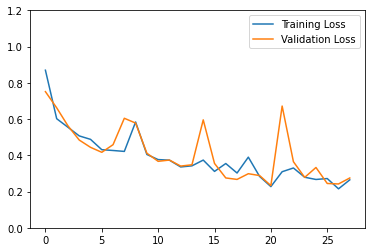

In [9]:
print(dataset, "1D CNN")
print("Final Validation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.ylim([0,1.2]) #for consistency - 1.2 has been a good value experimentally
plt.legend()
plt.show()

# Run the model - predict using the test data

1D CNN using Gesture Phase Segmentation - Prediction Accuracy: 0.897
              precision    recall  f1-score   support

        Rest       0.88      1.00      0.94       132
 Preparation       0.71      0.75      0.73        20
      Stroke       0.95      0.93      0.94       113
        Hold       0.00      0.00      0.00         7
  Retraction       1.00      0.10      0.18        10

    accuracy                           0.90       282
   macro avg       0.71      0.56      0.56       282
weighted avg       0.88      0.90      0.87       282



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


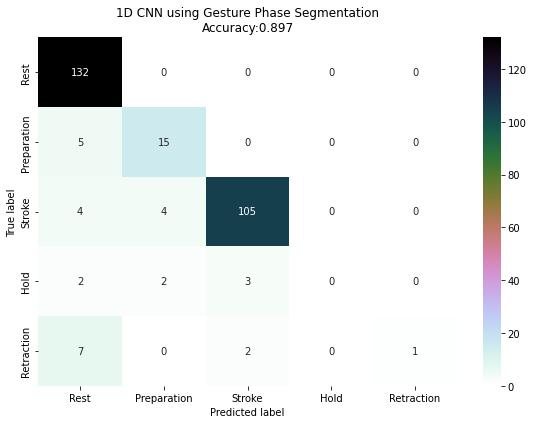

In [10]:
predictions = model.predict(x_test, verbose=0,batch_size=32)
#must use values not one-hot encoding, use argmax to convert
y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
y_test_act = np.argmax(y_test, axis=-1) # undo one-hot encoding
print("1D CNN using " + dataset + ' - Prediction Accuracy: {0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
#return (accuracy_score(y_temp, y_pred)),y_pred
y_test_act = np.argmax(y_test, axis=-1) #undo one-hot encoding
print(classification_report(y_test_act, y_pred, target_names=t_names))
cm = confusion_matrix(y_test_act, y_pred)
cm_df = pd.DataFrame(cm,
                     index = t_names, 
                     columns = t_names)
fig = plt.figure(figsize=(8,6)) # num classes => size
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
plt.title('1D CNN using '+dataset+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()